<a href="https://colab.research.google.com/github/vldrud/for_rodin/blob/master/Rud_Vladyslav_Analyze_WorkUa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

По этой ссылке находится полчаса жизни сайта Work.ua. 
\Если не получится обработать все полчаса, можно ограничиться любым более коротким интервалом, кратным 5 минутам.
 Необходимо ознакомиться с данными, обработать их и ответить на приведенные вопросы. 
Ответ — это число (или набор чисел) и описание способа получения такого результата (можно в виде SQL-запросов).

1. Сколько пользователей побывало на сайте?
2. Сколько страниц эти пользователи посмотрели?
3. Сколько человек пользовалось мобильным приложением Work.ua?
4. Сколько к нам приходило разных парсеров и что они искали?
5. Как распределены пользователи Android по версиям этой ОС?
6. Какие самые распространенные источники трафика?
7. Какой процент пользователей заходят с мобильных устройств, а какой — с десктопов?
8. Сколько новых пользовательских сессий было создано за это время?
9. Какую вакансию пользователи просматривали чаще всего?
10. Какое минимальное, максимальное и среднее время выполнения запроса?

Plan:
1. import libraries
2. import datset
3. Count users
4. Count viewed pages
5. Count phone users
6. Count parsers and pop views
7. Distribution of Android users per android's version
8. Most popular traffic sourses
9. Distribution of users per device
10. How many new user's sessions?
11. The popular position in work.ua
12. Min, Max, Mean time of request
13. Score

#### 1. Import libraries

In [ ]:
!pip install user_agents
!pip install swifter
!pip install urllib3

In [16]:
import os
import csv
import re

# for parsing the user-agent column
import user_agents
from user_agents import parse

from urllib.parse import urlparse

import numpy as np
import pandas as pd

# for optimizing the pandas apply function
import swifter

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import scipy.stats as stats

#### 2. import dataset

In [17]:
# import data
file = '/content/logs.csv'
data = pd.read_csv(file, sep=',', header=None, verbose=True)

# rename the columns from integers to good name
data = data.rename(columns={ 
                    0 : 'ip', 
                    1 : 'date_event', 
                    2 : 'request',
                    3 : 'url',
                    4 : 'status',
                    5 : 'column',
                    6 : 'referrer', 
                    7 : 'user_agent',
                    8 : 'req_time'
                    })

Tokenization took: 122.43 ms
Type conversion took: 102.03 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 79.97 ms
Type conversion took: 94.70 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 80.10 ms
Type conversion took: 92.17 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 84.91 ms
Type conversion took: 98.32 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 80.55 ms
Type conversion took: 98.92 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 77.60 ms
Type conversion took: 105.98 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 83.56 ms
Type conversion took: 102.53 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 78.96 ms
Type conversion took: 103.96 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 78.59 ms
Type conversion took: 97.86 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 80.33 ms
Type conversion took: 98.99 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 78.07 ms
Type conversion t

In [18]:
# view the first 10 rows
data.head(10)

,ip,date_event,request,url,status,column,referrer,user_agent,req_time
0,109.200.9.208,2021-04-12T12:00:00+03:00,GET,/_data/counter.php?&b[0]=127&nc[0]=1&b[1]=770&...,200,20,https://www.work.ua/ru/jobs/4068450/,Mozilla/5.0 (iPhone; CPU iPhone OS 12_5_1 like...,0.005
1,46.133.191.67,2021-04-12T12:00:00+03:00,GET,/_data/counter.php?&b[0]=106&nc[0]=1&b[1]=761&...,200,20,https://www.work.ua/ru/jobs/4291585/,Mozilla/5.0 (Linux; Android 11; SM-A705FN) App...,0.010
2,66.249.179.205,2021-04-12T12:00:00+03:00,GET,/en/jobs-other-beauty-sports-streamer/?categor...,200,15044,-,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,0.034
3,178.133.238.155,2021-04-12T12:00:00+03:00,POST,/social/fb-counter/,200,16,https://www.work.ua/ru/jobs/3169676/,Mozilla/5.0 (Linux; Android 10; M2007J3SG) App...,0.213
4,77.222.102.77,2021-04-12T12:00:00+03:00,POST,/social/fb-counter/,200,16,https://www.work.ua/jobs/3892446/,Mozilla/5.0 (Linux; Android 10; ART-L29; HMSCo...,0.009
5,176.37.204.153,2021-04-12T12:00:00+03:00,GET,/api/v1/notification/list/?beforeId=0&limit=50,200,3098,-,Work.ua.mobileApp/1.3.7 (ios/14.4.2),0.019
6,46.33.222.251,2021-04-12T12:00:00+03:00,POST,/api/v1/jobseeker/personal-feed/new/,200,71,-,Work.ua.mobileApp/1.3.7 (ios/14.4.2),0.030
7,46.185.236.224,2021-04-12T12:00:00+03:00,POST,/ajax/jobseeker/my/personal-feed/new/,200,813,https://www.work.ua/ru/jobseeker/my/personal-f...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0.087
8,195.64.21.222,2021-04-12T12:00:00+03:00,GET,/_data/_ajax/search-hint.php?search=%D1%82%D1%...,200,90,https://www.work.ua/ru/resumes/,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,0.009
9,82.145.47.71,2021-04-12T12:00:00+03:00,GET,/_data/counter.php?b[0]=3364&nc[0]=1&rnd=60740...,200,31,https://www.work.ua/ru/jobs-ivano-frankivsk/?p...,Opera/9.80 (J2ME/MIDP; Opera Mini/4.5.33867/19...,0.002


In [19]:
# view the last 10 rows
data.tail(10)

,ip,date_event,request,url,status,column,referrer,user_agent,req_time
870288,46.98.175.97,2021-04-12T12:29:59+03:00,GET,/ru/jobs-dnipro/?days=122&page=19,200,24802,https://www.work.ua/ru/jobs/?region=34&days=122,Mozilla/5.0 (Linux; Android 10; Redmi Note 7) ...,0.149
870289,151.236.254.240,2021-04-12T12:29:59+03:00,GET,/ru/resumes-kyiv-%D0%BC%D0%B5%D0%BD%D0%B5%D0%B...,200,21429,https://www.work.ua/ru/resumes/6967509/,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,0.345
870290,45.140.134.31,2021-04-12T12:29:59+03:00,GET,/_data/_ajax/search-hint.php?search=%D0%BC%D0%...,200,478,https://www.work.ua/ru/resumes-odesa-%D0%BC%D0...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0.038
870291,5.58.142.156,2021-04-12T12:29:59+03:00,POST,/_data/_ajax/cities.php,200,63,https://www.work.ua/jobs/,Mozilla/5.0 (Linux; Android 10; SM-A305FN) App...,0.026
870292,94.244.81.63,2021-04-12T12:29:59+03:00,GET,/jobs/4295629/,200,16679,https://www.work.ua/jobs-kyiv/?advs=1&experien...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0.063
870293,178.133.231.109,2021-04-12T12:29:59+03:00,GET,/favicon.ico,200,2395,-,Dalvik/2.1.0 (Linux; U; Android 7.1.1; MI MAX ...,0.000
870294,195.114.110.229,2021-04-12T12:29:59+03:00,GET,/jobseeker/my/,200,5449,https://www.work.ua/jobseeker/my/resumes/,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0.021
870295,88.155.239.227,2021-04-12T12:29:59+03:00,POST,/_data/_ajax/cities.php,200,62,https://www.work.ua/jobs/by-company/133403/,Mozilla/5.0 (Linux; Android 9; AMN-LX9) AppleW...,0.012
870296,188.163.145.235,2021-04-12T12:29:59+03:00,POST,/ajax/jobseeker/my/personal-feed/new/,200,4652,https://www.work.ua/ru/jobseeker/my/personal-f...,Mozilla/5.0 (Linux; Android 7.0; ASUS_X008DC B...,0.084
870297,91.218.60.110,2021-04-12T12:29:59+03:00,GET,/static/i/telegram@2x.png,200,3767,https://www.work.ua/jobs-brovary/?gclid=Cj0KCQ...,Mozilla/5.0 (Linux; Android 8.1.0; SM-J710F) A...,0.000


In [20]:
data.describe()

,status,column,req_time
count,870298.000000,8.702980e+05,870298.000000
mean,210.983862,9.149978e+03,0.068614
std,44.520984,1.942861e+04,0.340362
min,200.000000,0.000000e+00,0.000000
25%,200.000000,2.500000e+01,0.010000
50%,200.000000,1.824000e+03,0.026000
75%,200.000000,1.391900e+04,0.068000
max,499.000000,1.044939e+06,92.645000


In [21]:
data[['ip', 'referrer', 'date_event', 'user_agent']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870298 entries, 0 to 870297
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ip          870298 non-null  object
 1   referrer    870298 non-null  object
 2   date_event  870298 non-null  object
 3   user_agent  870298 non-null  object
dtypes: object(4)
memory usage: 26.6+ MB


#### 3. Count users.  I make it by ip

In [22]:
count_users = data[['ip', 'request']].groupby(['ip'], ).count()
print('num users: ', count_users.shape[0])

num users:  39074


#### 4. Count viewed pages

In [23]:
# grouping pages by url
count_pages_url = data['url'].groupby(data['url']).count()

# grouping pages by referrer
work_ua_pages_referrer = data['referrer'][data['referrer'].str.find('work.ua') != -1]
count_pages_referrer = work_ua_pages_referrer.groupby(work_ua_pages_referrer).count()

# printing the count of all viewed pages
print('viewed pages num:' , count_pages_referrer.shape[0] + count_pages_url.shape[0])

viewed pages num: 542130


#### 5. Count phone users

At first, let's parse user-agent for finding: browser, device, is it a bot and versions of all of this

In [24]:
# initializing the functions for checking 
# bots
def bot_check(string, verbose=False):
    if verbose == True:
        print(bot_check.__name__, len(string))
    if string.is_bot:
        return 1
    else:
        return 0

# mobiles
def mobile_check(string, verbose=False):
    if verbose == True:
        print(mobile_check.__name__, len(string))
    if string.is_mobile:
        return 1
    else:
        return 0    

# pc
def pc_check(string, verbose=False):
    if verbose == True:
        print(pc_check.__name__, len(string))
    if string.is_pc:
        return 1
    else:
        return 0

# browser parser
def parse_browser(string):
    return string.browser.family

# browser version parser
def parse_browser_version(string):
    return string.browser.version_string

# os parser
def parse_os(string):
    return string.os.family

# os version parser
def parse_os_version(string):
    return string.os.version_string

# create the new var system data which contain ip and user-agent values    
system_data = data[['ip', 'user_agent']]
print('system data is created')

# add new column 'parser' which contains user-agents parse objects
# it is the most heavy part for time
system_data['parser'] = system_data['user_agent'].swifter.apply(parse)
print('parser is created')

# adding new info from user_agent column
# browser
system_data['browser'] = system_data['parser'].swifter.apply(parse_browser)
print('browser data is created')

# browser version
system_data['browser_version'] = system_data['parser'].swifter.apply(parse_browser_version)
print('browser version data is created')

# os
system_data['os'] = system_data['parser'].swifter.apply(parse_os)
print('os data is created')

# os version
system_data['os_version'] = system_data['parser'].swifter.apply(parse_os_version)
print('os version data is created')

# apply the initialized functions
system_data['is_bot'] = system_data['parser'].swifter.apply(bot_check, verbose=False)
system_data['is_mobile'] = system_data['parser'].swifter.apply(mobile_check, verbose=False)
system_data['is_pc'] = system_data['parser'].swifter.apply(pc_check, verbose=False)


system data is created



parser is created


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



browser data is created


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



browser version data is created


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



os data is created


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



os version data is created


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
# let's watch what table we give
system_data

,ip,user_agent,parser,browser,browser_version,os,os_version,is_bot,is_mobile,is_pc
0,109.200.9.208,Mozilla/5.0 (iPhone; CPU iPhone OS 12_5_1 like...,iPhone / iOS 12.5.1 / Mobile Safari 12.1.2,Mobile Safari,12.1.2,iOS,12.5.1,0,1,0
1,46.133.191.67,Mozilla/5.0 (Linux; Android 11; SM-A705FN) App...,Samsung SM-A705FN / Android 11 / Chrome Mobile...,Chrome Mobile,89.0.4389,Android,11,0,1,0
2,66.249.179.205,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,Spider / Android 6.0.1 / Googlebot 2.1,Googlebot,2.1,Android,6.0.1,1,1,0
3,178.133.238.155,Mozilla/5.0 (Linux; Android 10; M2007J3SG) App...,M2007J3SG / Android 10 / Chrome Mobile 89.0.4389,Chrome Mobile,89.0.4389,Android,10,0,1,0
4,77.222.102.77,Mozilla/5.0 (Linux; Android 10; ART-L29; HMSCo...,Huawei Browser / Android 10 / Chrome 83.0.4103,Chrome,83.0.4103,Android,10,0,1,0
...,...,...,...,...,...,...,...,...,...,...
870293,178.133.231.109,Dalvik/2.1.0 (Linux; U; Android 7.1.1; MI MAX ...,XiaoMi MI MAX 2 / Android 7.1.1 / Android 7.1.1,Android,7.1.1,Android,7.1.1,0,0,0
870294,195.114.110.229,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,PC / Windows 10 / Chrome 89.0.4389,Chrome,89.0.4389,Windows,10,0,0,1
870295,88.155.239.227,Mozilla/5.0 (Linux; Android 9; AMN-LX9) AppleW...,Huawei AMN-LX9 / Android 9 / Chrome Mobile 85....,Chrome Mobile,85.0.4183,Android,9,0,1,0
870296,188.163.145.235,Mozilla/5.0 (Linux; Android 7.0; ASUS_X008DC B...,Asus X008DC / Android 7.0 / Chrome Mobile 69.0...,Chrome Mobile,69.0.3497,Android,7.0,0,1,0


In [26]:
# grouping user's by their ip, exclude the bots
phone_users = system_data['ip'][
    (system_data['is_mobile'] == 1) & \
    (system_data['is_bot'] == 0)].groupby(system_data['ip']).count()
phone_users.sort_values(ascending=False)

ip
66.249.172.207    399
66.249.172.209    375
94.153.171.205    371
185.11.227.131    367
66.249.172.205    349
                 ... 
212.9.16.21         1
212.55.175.27       1
212.3.146.217       1
212.22.32.173       1
102.176.161.90      1
Name: ip, Length: 19529, dtype: int64

In [27]:
print('phone users num: ', phone_users.shape[0])

phone users num:  19529


#### 6. Count parsers and pop views

From habr you can know that parsers are identifieds as bots. That's why let's found number of bots

In [28]:
# grouping system_data by 'ip' for bot's counting
bot_ip = system_data['ip'][system_data['is_bot'] == 1].groupby(system_data['ip']).count()

# printing the bots ip
bot_ip.sort_values(ascending=False)

ip
176.37.107.159    6062
176.9.163.36      2660
5.255.24.187      1518
5.255.2.94        1495
213.180.52.142    1403
                  ... 
54.36.107.151        1
40.77.65.94          1
54.36.107.147        1
40.77.66.112         1
98.139.122.83        1
Name: ip, Length: 1503, dtype: int64

In [29]:
# printing the number of bots
print('bots num: ', bot_ip.shape[0])

bots num:  1503


And find the most popular page for every bot

In [30]:
### concate the urls and is_bot columns
bot_urls = pd.concat([system_data['ip'], system_data['is_bot'], data['url'], system_data['browser']], axis=1)

# filtering the bots
bot_urls = bot_urls[bot_urls['is_bot'] == 1]

# grouping by url for finding the most popular url for bots
bot_urls = bot_urls['url'].groupby(bot_urls['url']).count().sort_values(ascending=False)
bot_urls = pd.DataFrame(bot_urls).rename(columns={'url' : 'count'}).reset_index()

# printing the top 10 urls for bots
bot_urls[bot_urls['count'] > 10].head(10)

,url,count
0,/social/fb-counter/,1991
1,/export/informer/get_details.php?id=22,1095
2,/_data/_ajax/cities.php,1000
3,/export/informer/get_details.php?id=23,628
4,/export/informer/get_details.php?id=140,376
5,/export/informer/get_details.php?id=175,340
6,/favicon.ico,124
7,/b.php?bid=3238,123
8,/apple-touch-icon.png,122
9,/apple-touch-icon-precomposed.png,122


#### 7. Distribution of Android users per android's version

Bots are included in this calculations

In [31]:
# print the OS on site
system_data['os'].unique()
# omg Symbian??????

array(['iOS', 'Android', 'Other', 'Windows', 'Mac OS X', 'Linux',
       'Ubuntu', 'Windows Phone', 'Symbian OS', 'KaiOS', 'Chrome OS',
       'Tizen', 'Fedora', 'FreeBSD'], dtype=object)

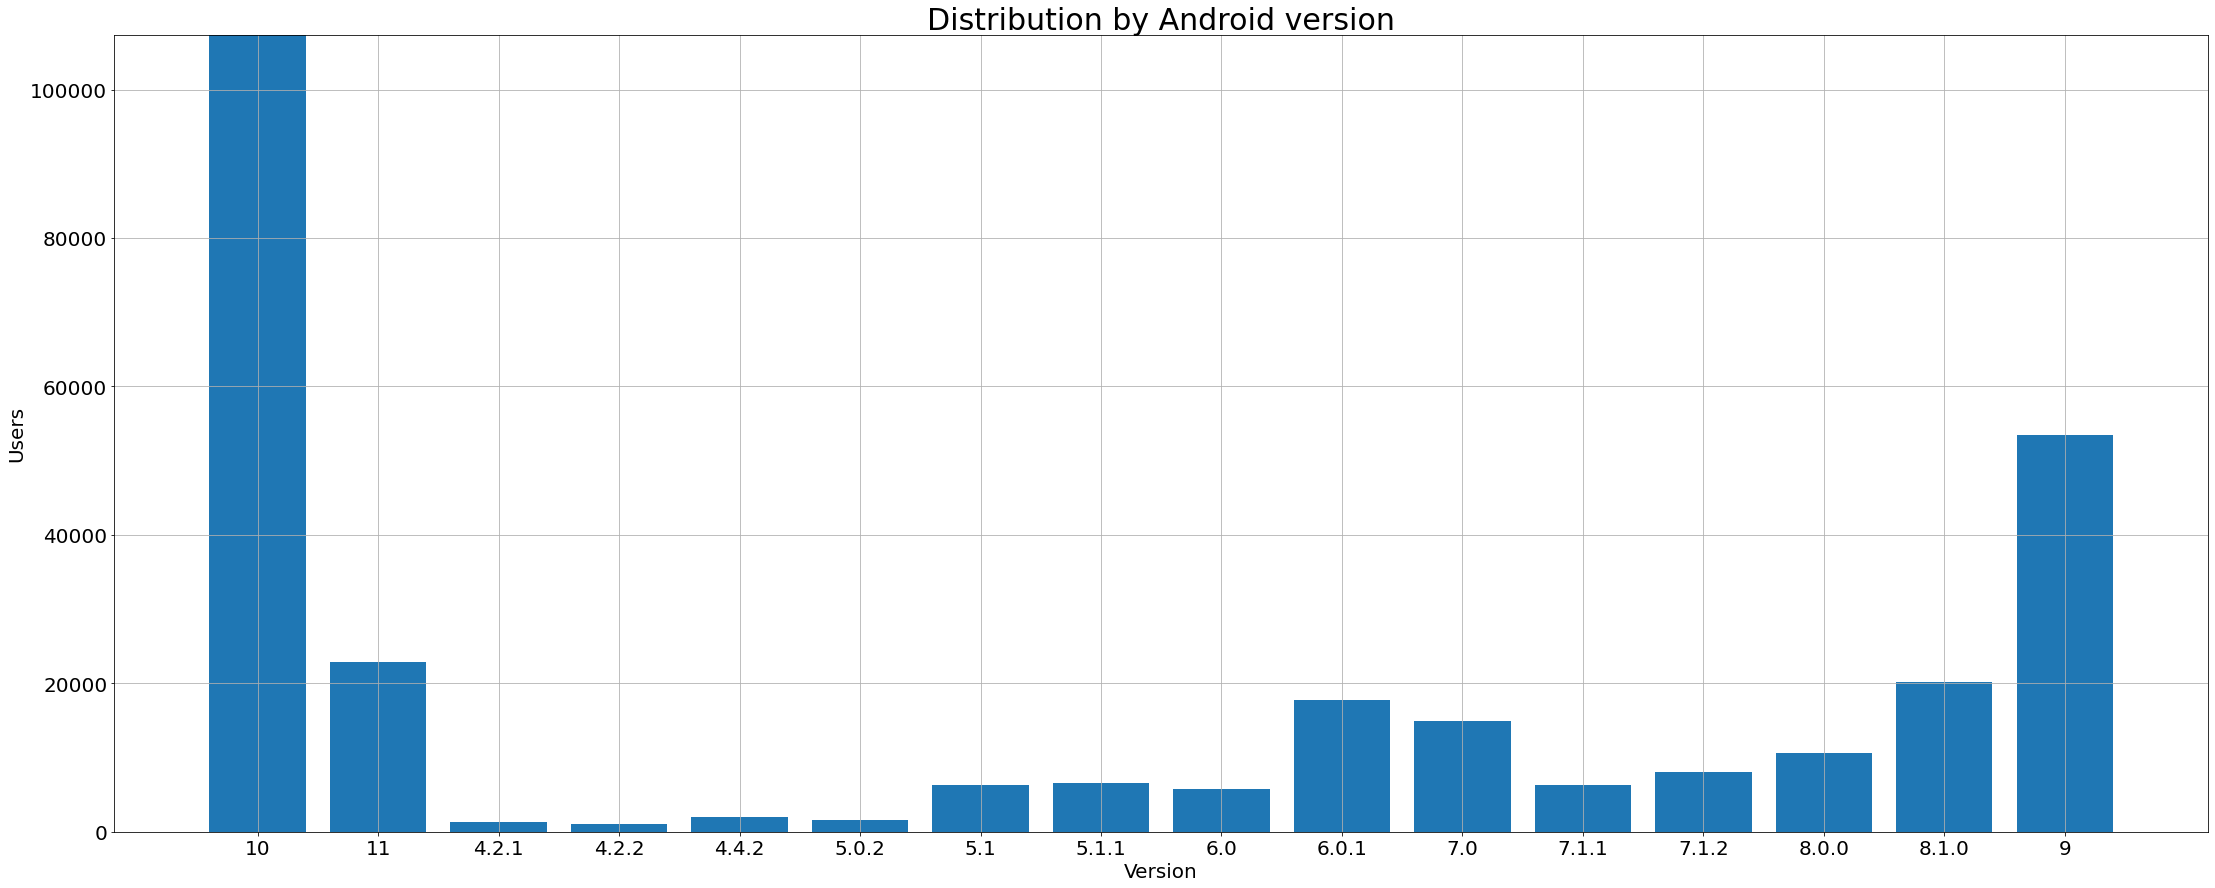

,os_version,count
0,10,107307
1,11,22879
2,2.2,15
3,2.2.2,7
4,2.3.3,3
5,2.3.4,4
6,2.3.5,2
7,2.3.6,90
8,4.0.4,41
9,4.1,3


In [32]:
# printing the bar
def plt_bar(x, y, grid=True, hight=12, weight=30, plotname='bar', xlabel='x', ylabel='y'):        
    plt.figure(figsize=(weight, hight))
    plt.grid(grid)
    plt.bar(x, y)
    plt.ylim(0, y.max())
    plt.title(plotname, fontsize=weight)
    plt.tight_layout(h_pad = -0.15, w_pad = -0.2)
    # labels for every axis
    plt.xlabel(xlabel, fontsize=weight-10)
    plt.ylabel(ylabel, fontsize=weight-10)
    # ticks
    plt.tick_params(axis='x', labelsize=weight-10)
    plt.tick_params(axis='y', labelsize=weight-10)
    plt.show()
    
    
# getting only android users
version_users = system_data[['ip', 'os_version']][system_data['os'] == 'Android']

# replace the the duplicate values
version_users['os_version'] = version_users['os_version'].replace({
                                                                    '10.0' : '10',
                                                                    '9.0'  : '9',
                                                                    '7.0.0' : '7.0',
                                                                    '' : 'Nans'
                                                                  })  
# grouping by os_version and count all 
version_users = version_users.groupby('os_version', dropna=True).count()
version_users = version_users.reset_index().rename(columns={'ip' : 'count'})

# filtering version_users for getting more popular versions >1000
popular_version_users = version_users[version_users['count'] >= 1000]

# printing the histogram of distribution per version
plt_bar(x=popular_version_users['os_version'], 
        y=popular_version_users['count'], 
        plotname='Distribution by Android version' , xlabel='Version', ylabel='Users')
version_users  

#### 8. Most popular traffic sourses

In [33]:
# take sample in which referrers don't contain work.ua
traffic = data['referrer'][data['referrer'].str.find('work.ua') == -1]

# parse the traffic var for finding the netloc 
traffic = traffic.apply(lambda x: urlparse(x).netloc)

# print the top 20 popular traffic sourses
traffic.groupby(traffic).count().sort_values(ascending=False).head(20)

referrer
                                           201365
www.google.com                              29330
www.google.com.ua                            3506
secureurl.ukr.net                            2782
com.google.android.gm                        1223
mykharkov.info                                923
mail.google.com                               271
org.telegram.messenger                        255
smartlab.com.ua                               225
www.google.ru                                 211
webmail.meta.ua                               211
www.uarabota.com.ua                           206
yandex.ua                                     174
www.ukr.net                                   160
mbox2.touch.i.ua                              158
mail.rambler.ru                               146
com.google.android.googlequicksearchbox       126
googleads.g.doubleclick.net                   117
dnepr.com                                     113
angio.com.ua                             

#### 9. Distribution users per device

In [34]:
# the number of pc users
num_pc_users = system_data['ip'][
                                (system_data['is_pc'] == 1) & 
                                (system_data['is_bot'] == 0)].groupby(system_data['ip']).count().shape[0]

# the number of phone users
num_mobile_users = phone_users.shape[0]

# the number of bots
num_bots = bot_ip.shape[0]

# full number of users
num_users = count_users.shape[0]

# printing the result
print(' percent pc-users: ', np.round(num_pc_users / (num_users - num_bots) * 100, 0),'%','\n', 
      'percent mobile-users: ', np.round(num_mobile_users / (num_users - num_bots) * 100, 0),'%','\n')
print(' num pc-users: ', num_pc_users, '\n', 
      'num mobile-users: ', num_mobile_users, '\n',
      'num bots: ', num_bots, '\n',
      'full num users: ', num_users)

 percent pc-users:  37.0 % 
 percent mobile-users:  52.0 % 

 num pc-users:  13898 
 num mobile-users:  19529 
 num bots:  1503 
 full num users:  39074


The other percent - maybe are tablets

#### 10. The number of user's sessions

-

#### 11. The most popular job

In [35]:
# parse url by sent CV 
jobs = data[['url', 'request']][(data['url'].str.find('jobseeker/my/resumes/sent/') != -1)]

# parse for getting id of job
jobs['job_id'] = jobs['url'].apply(lambda x: re.search('\d+', x).group(0))
jobs

,url,request,job_id
14,/ru/jobseeker/my/resumes/sent/?job_id=3901907,GET,3901907
730,/jobseeker/my/resumes/sent/?job_id=4242049,GET,4242049
1003,/ru/jobseeker/my/resumes/sent/?job_id=4059450,GET,4059450
1913,/jobseeker/my/resumes/sent/?job_id=4291340,GET,4291340
2811,/ru/jobseeker/my/resumes/sent/?job_id=4263423,GET,4263423
...,...,...,...
868332,/ru/jobseeker/my/resumes/sent/?job_id=4092612,GET,4092612
868707,/ru/jobseeker/my/resumes/sent/?job_id=4276727,GET,4276727
868810,/jobseeker/my/resumes/sent/?job_id=4272128,GET,4272128
869169,/ru/jobseeker/my/resumes/sent/?job_id=4291571,GET,4291571


In [36]:
# we need a parse a site for getting full information about position id
jobs['job_id'].groupby(jobs['job_id']).count().sort_values(ascending=False)

job_id
4295046    13
3877908     7
4295351     6
4281963     5
4295374     5
           ..
4272120     1
4272128     1
4272140     1
4272161     1
1022656     1
Name: job_id, Length: 2108, dtype: int64

Let's watch the popular position in this 30 min's period 

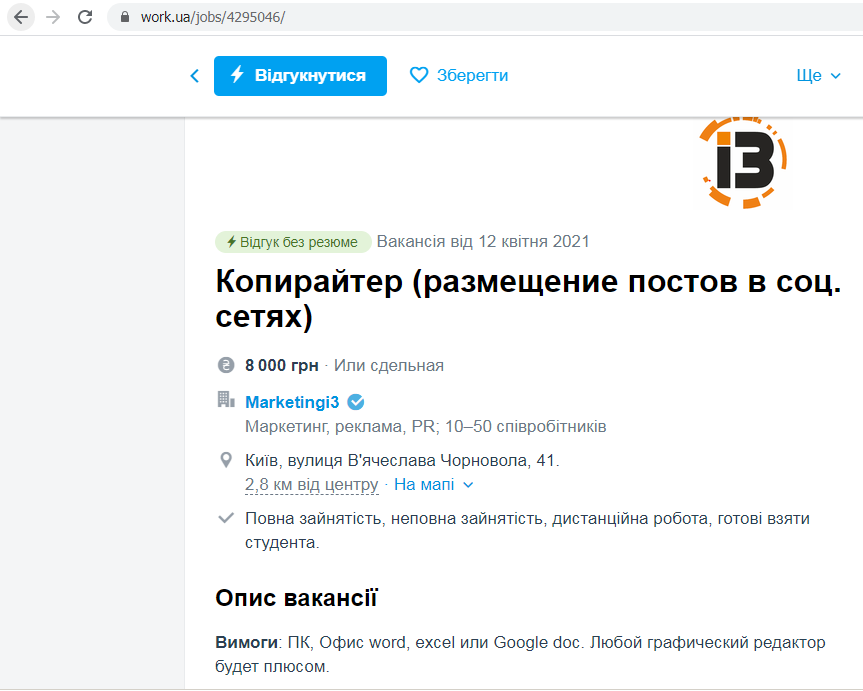

#### 12. Min, Max, Mean for each request

Let's print the distribution of time for every request

In [37]:
# procedure for printing the histogram
def plot_plt_histogram(set_x, bins, grid=False, height=70, width=100, fontsize=30,
                       need_xlim=False, xlim=1000, xmin=0,
                       need_ylim=False, ylim=1000, ymin=0,
                       xlabel='value', ylabel='num',
                       hist_name='Histogram'):
    # plotting the histogram
    plt.figure(figsize=(width, height))
    plt.hist(set_x, bins=bins)
    if need_xlim == True:
        plt.xlim(xmin, xlim)
    if need_ylim == True:
        plt.ylim(ymin, ylim)
    plt.title(hist_name, fontsize=fontsize)
    plt.grid(grid)
    # labels for every axis
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    # ticks
    plt.tick_params(axis='x', labelsize=fontsize)
    plt.tick_params(axis='y', labelsize=fontsize)
    plt.show()

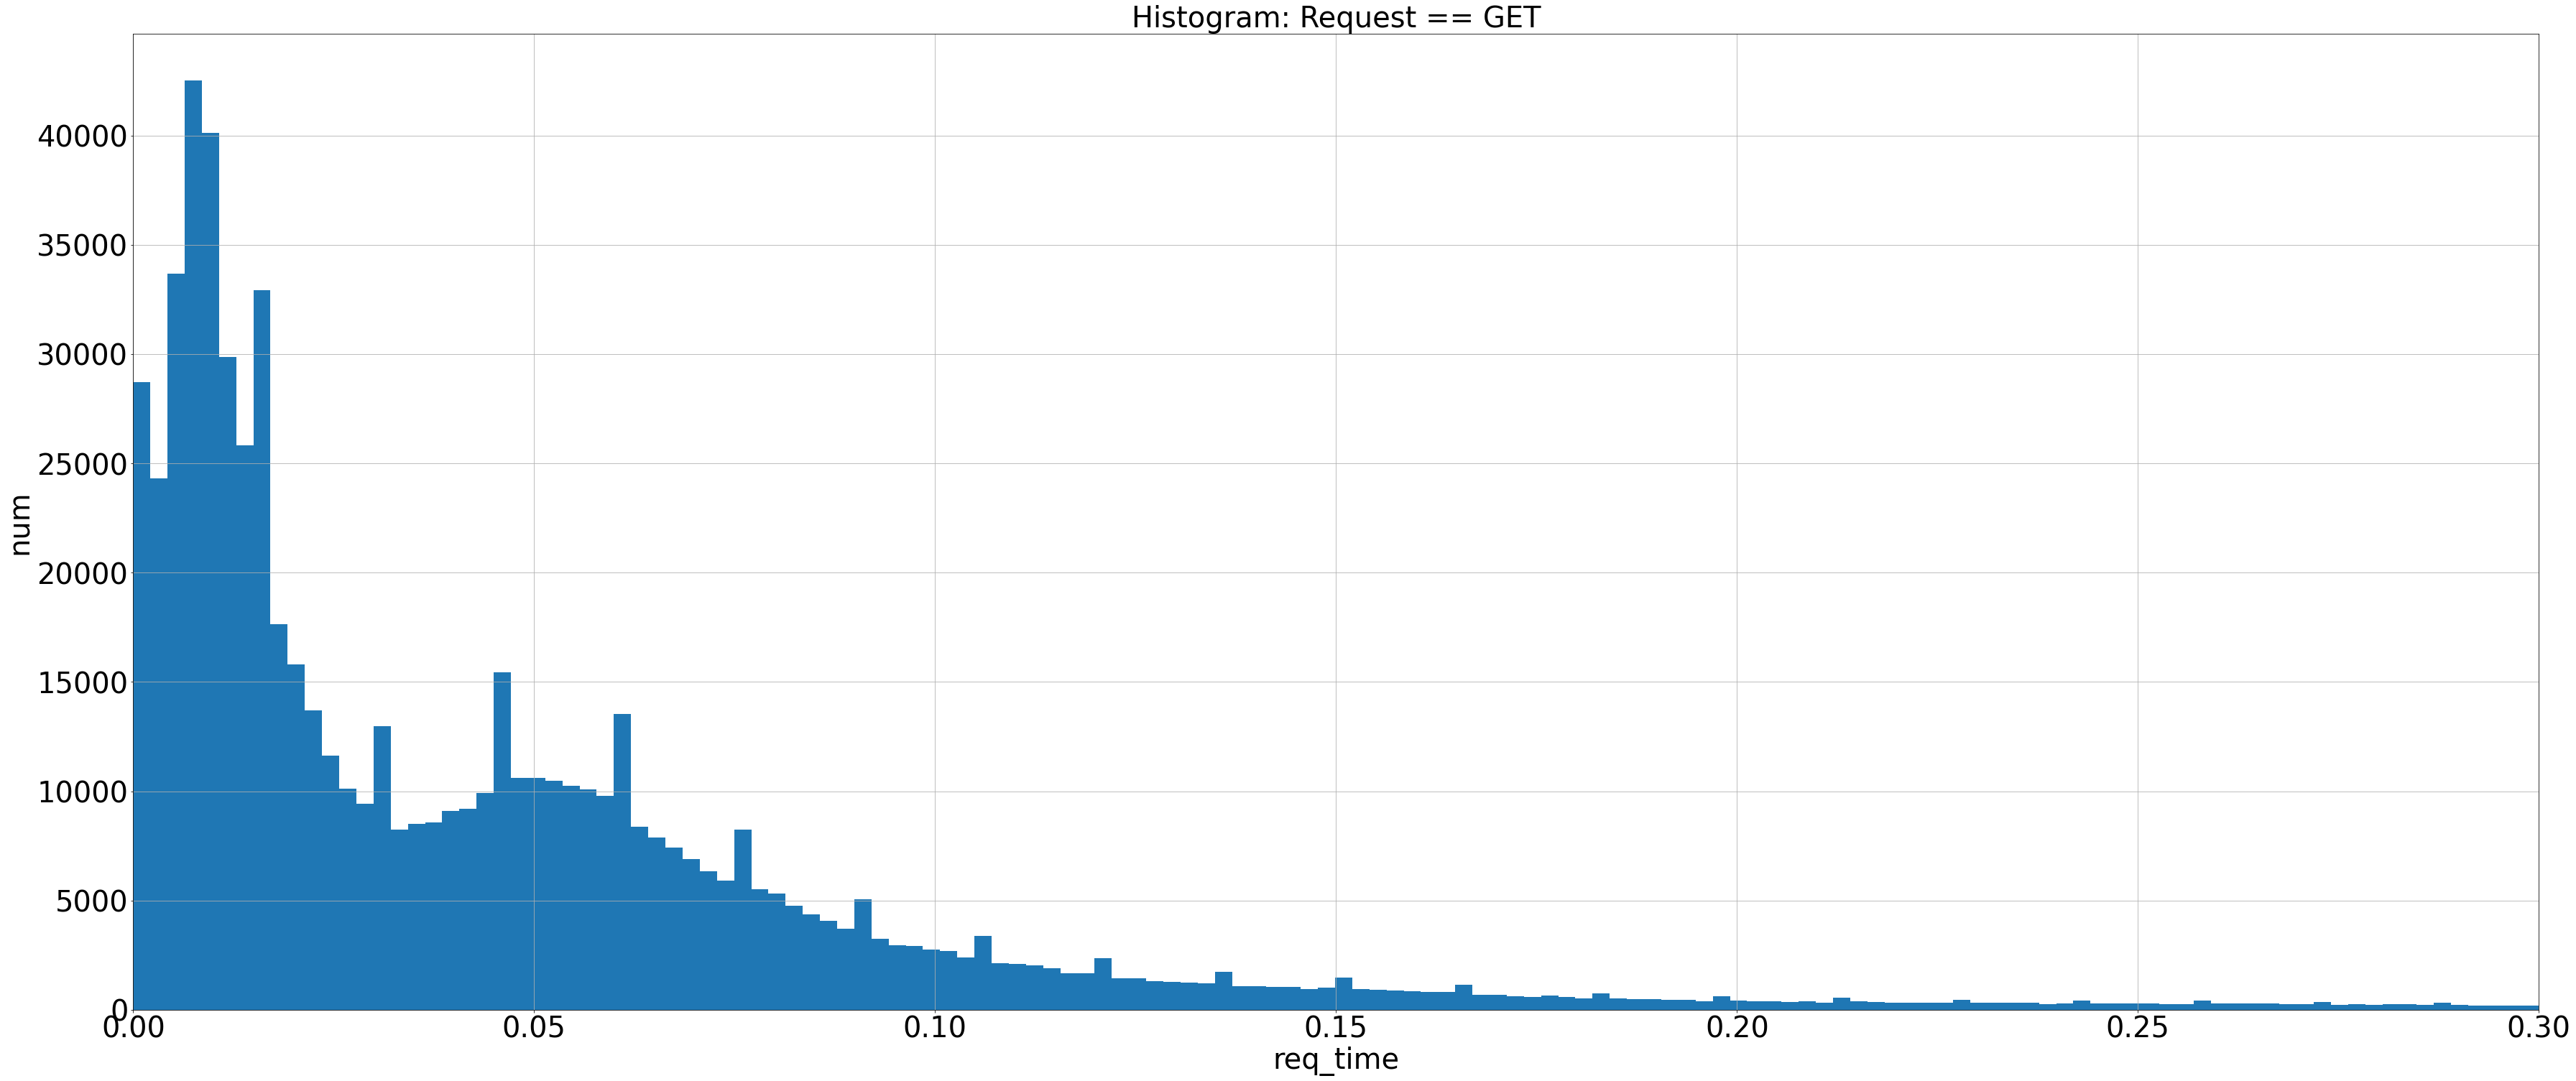

 min GET req_time:  0.0 
 max GET req_time:  64.233 
 mean GET req_time:  0.06529404693328843 
 median GET req_time:  0.03 
 mode GET req_time:  0    0.008
dtype: float64 



In [38]:
# sample with GET requests
get_req_dist = data['req_time'][data['request'] == 'GET']

# printing the histogram of req_time of GET request
plot_plt_histogram(get_req_dist, bins=30000, hist_name='Histogram: Request == GET',
                   grid=True, height=25, width=60, fontsize=40, xlabel='req_time', 
                   need_xlim=True, xmin=0, xlim=0.3)
# printing the decribe statistic
print(' min GET req_time: ',get_req_dist.min(), '\n',
       'max GET req_time: ',get_req_dist.max(), '\n',
       'mean GET req_time: ',get_req_dist.mean(), '\n', 
       'median GET req_time: ',get_req_dist.median(), '\n',
       'mode GET req_time: ',get_req_dist.mode(), '\n',)

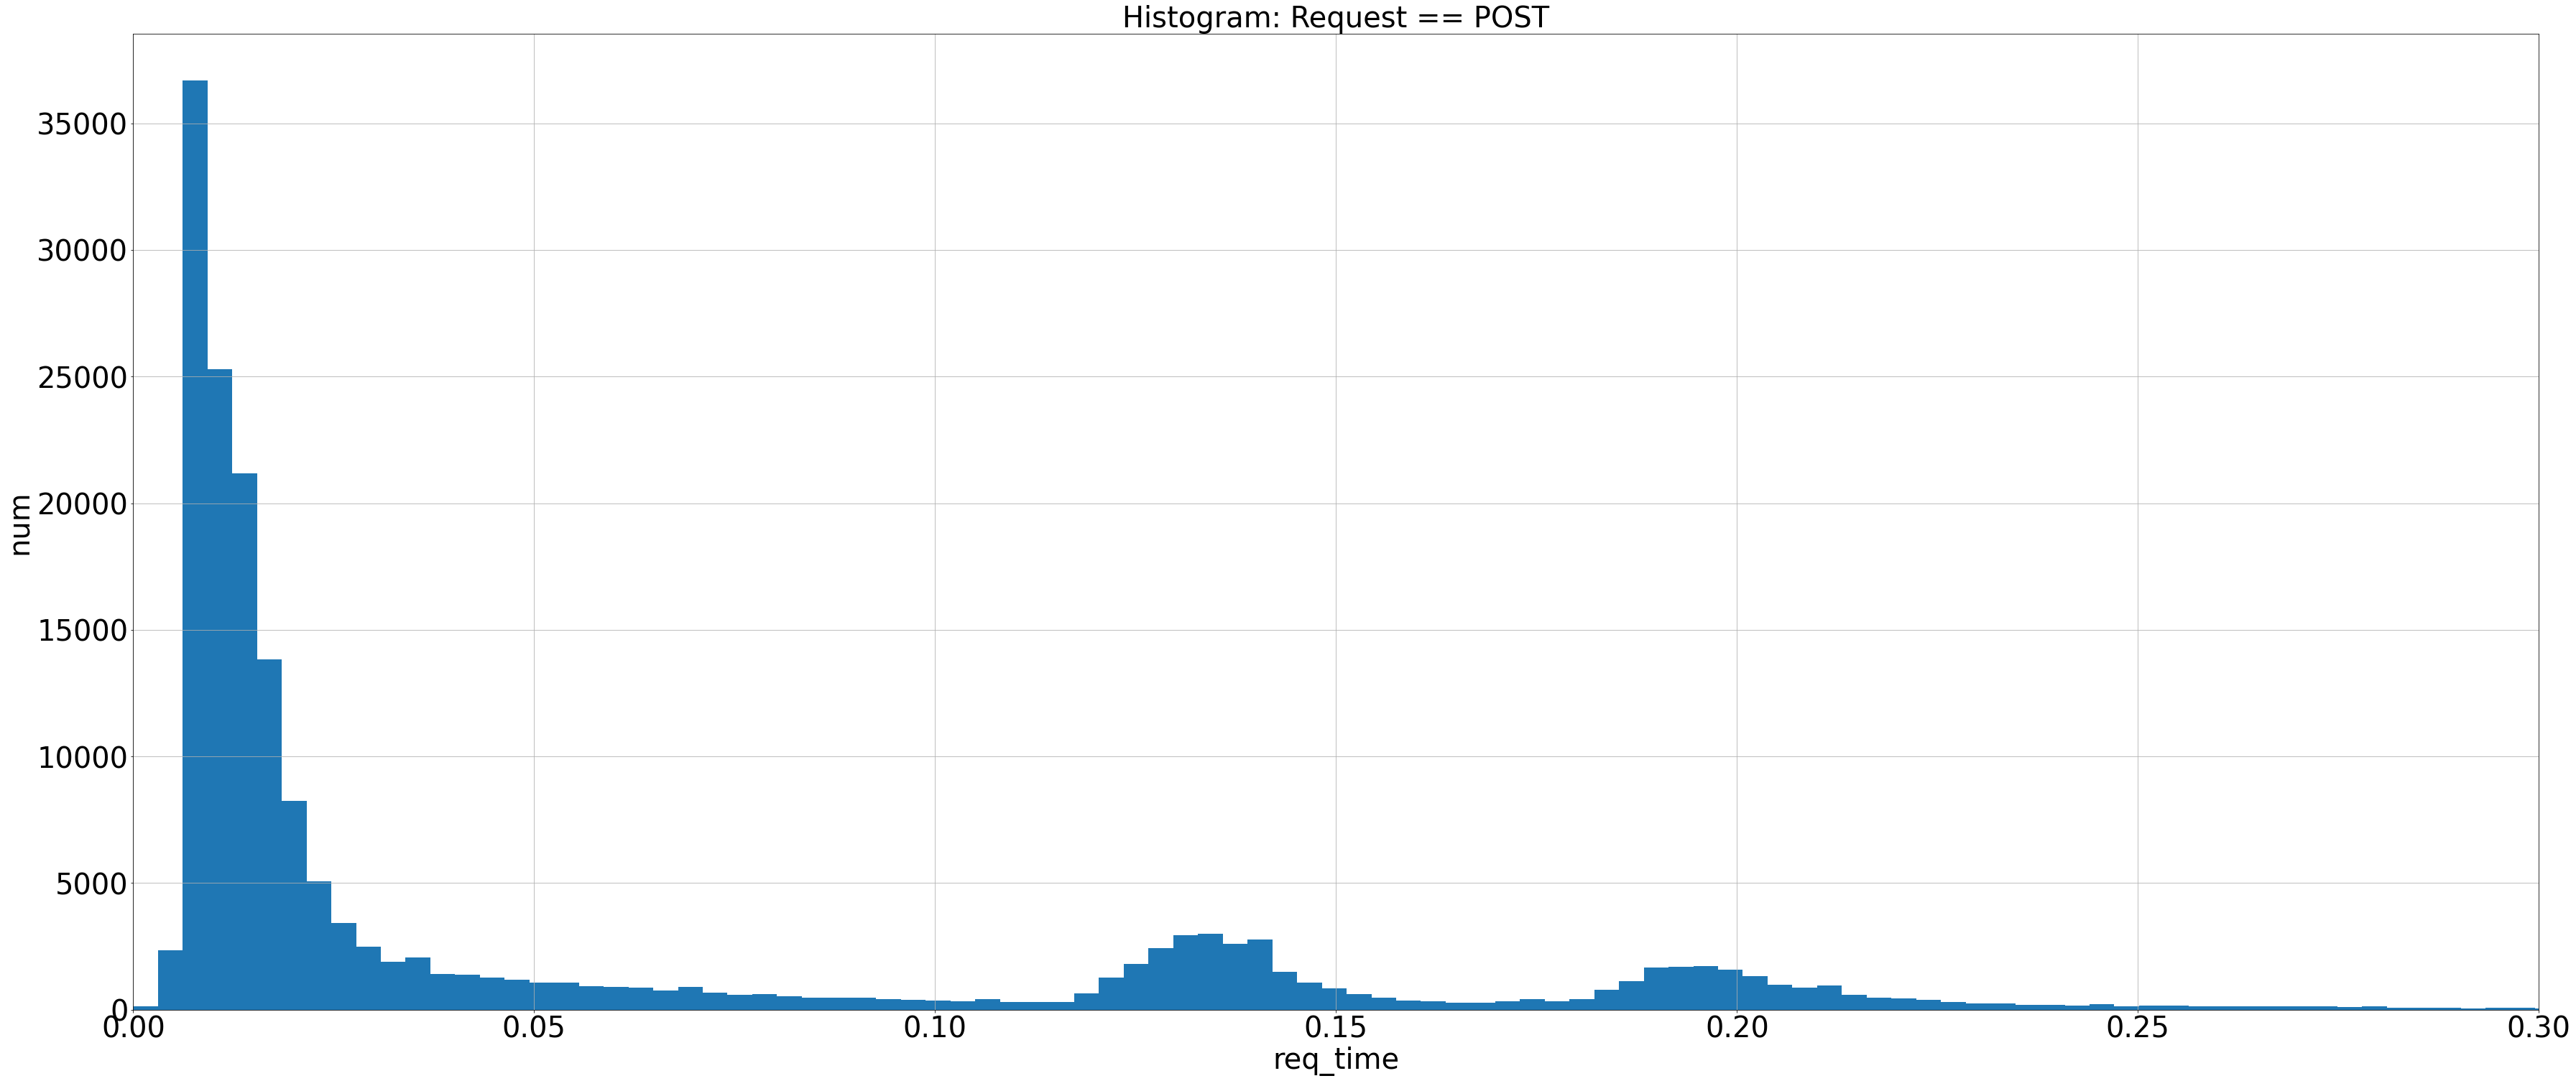

 min POST req_time:  0.0 
 max POST req_time:  92.645 
 mean POST req_time:  0.0810242035657828 
 median POST req_time:  0.017 
 mode POST req_time:  0    0.008
dtype: float64 



In [39]:
# sample with POST requests
post_req_dist = data['req_time'][data['request'] == 'POST']

# printing the histogram of req_time of POST request
plot_plt_histogram(post_req_dist, bins=30000, hist_name='Histogram: Request == POST',
                   grid=True, height=25, width=60, fontsize=40, xlabel='req_time', 
                   need_xlim=True, xmin=0, xlim=0.3)
# printing the decribe statistic
print(' min POST req_time: ',post_req_dist.min(), '\n',
       'max POST req_time: ',post_req_dist.max(), '\n',
       'mean POST req_time: ',post_req_dist.mean(), '\n', 
       'median POST req_time: ',post_req_dist.median(), '\n',
       'mode POST req_time: ',post_req_dist.mode(), '\n',)

# Score

I solve 9/10 tasks and use two libraries for parsing the text data. My job is not ideal, but we can get any thinking about users and their technic details.

Please give me a feedback about my executed job.